In [44]:
# importation des librairies utilisées après
# pour utiliser pybert
import pybert as pb
# pour faire des opérations (comme loadtxt)
import numpy as np
# pour regarder la topo
import matplotlib.pyplot as plt
# pour utiliser pygimli
import pygimli as pg
# importer directement ert, cela évite d'écrire à chaque fois: pg.physics.ert...
from pygimli.physics import ert as ert_m

In [45]:
# définition en dure des fichiers de données (attention / et non \ pour l'adresse des répertoires)

# fichier des données
infile='C:\\Users\\rugsr\\integration_de_donnees\\partie_ert-20230306\\WS96RA-1m.bin'
# fichier topographie
topofile='C:\\Users\\rugsr\\integration_de_donnees\\partie_ert-20230306\\Topo-pas1m.dat'
# fichier de sortie des données filtrés, traités, etc.
outfile='C:\\Users\\rugsr\\integration_de_donnees\\partie_ert-20230306\\WS72_1m.txt'

## Partie 1: Traitement des données

In [46]:
# lecture des données acquis avec le SyscalPro (IRIS Instruments)
data=pb.importData(infile)

14/04/23 - 16:40:03 - pyGIMLi - INFO - imported:  Data: Electrodes: 192 data: 7097


In [47]:
#Voir paramètres importés. 
print(data.tokenList())

SensorIdx: a b m n  Data: M1 M10 M11 M12 M13 M14 M15 M16 M17 M18 M19 M2 M20 M3 M4 M5 M6 M7 M8 M9 TM0 TM1 TM10 TM11 TM12 TM13 TM14 TM15 TM16 TM17 TM18 TM19 TM2 TM20 TM3 TM4 TM5 TM6 TM7 TM8 TM9 bat_rx bat_tx err gm i ip iperr k r rhoa rs_check sp stacks temp u vab valid 


(<AxesSubplot:>, <matplotlib.colorbar.Colorbar at 0x28aa477cf10>)

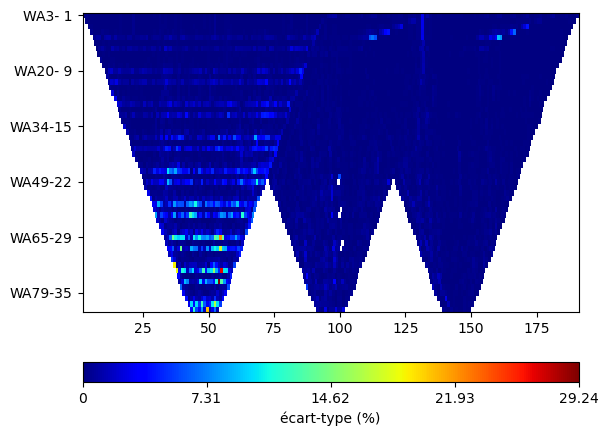

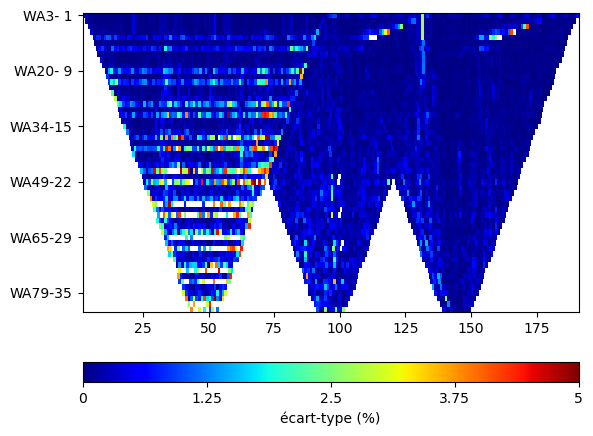

In [48]:
# représentation de l'écart-type sur les données
pb.show(data,'err',label='écart-type (%)',logScale=False)
# filtrage des données ayant un écart-type trop élevé (>5%)
data.markInvalid(data('err')>5)
# représentation de l'écart-type sur les données, après filtrage
pb.show(data,'err',label='écart-type (%)',logScale=False)

(<AxesSubplot:>, <matplotlib.colorbar.Colorbar at 0x28aa5b76460>)

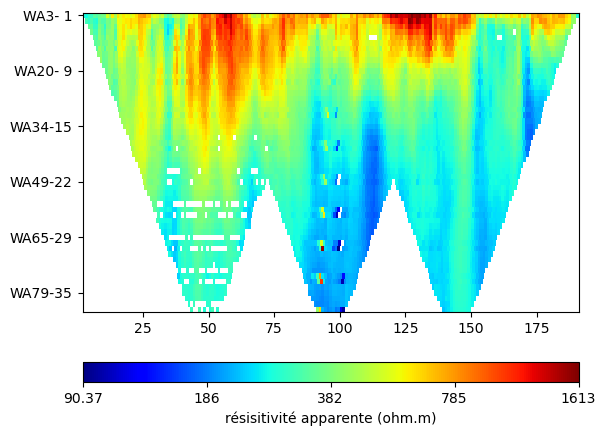

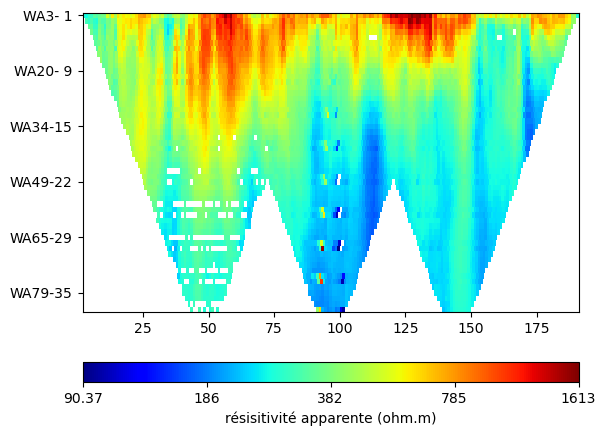

In [49]:
# calcul du coefficient géométrique
k=pb.geometricFactors(data)
data.set('k',k)
# calcul de la résistivité apparente
data.set('rhoa',data('u')/data('i')*data('k'))
# représentation de la résistivité apparente
pb.show(data,label='résisitivité apparente (ohm.m)')
# filtrage des résistivités apparentes, avec suppression des valeurs négatives
data.markInvalid(data('rhoa')<=0.01)
# représentation de la résistivité apparente, après filtrage
pb.show(data,label='résisitivité apparente (ohm.m)')

In [50]:
# importation de ERTManager de pybert
mgr=ert_m.ERTManager(data)
# pour les données hors norme, mettre zéro
mgr.data('rhoa')[mgr.data('rhoa')<=0] = 0;
mgr.data('rhoa')[np.isinf(mgr.data('rhoa'))] = 0;

(<AxesSubplot:>, <matplotlib.colorbar.Colorbar at 0x28aa5a9ab50>)

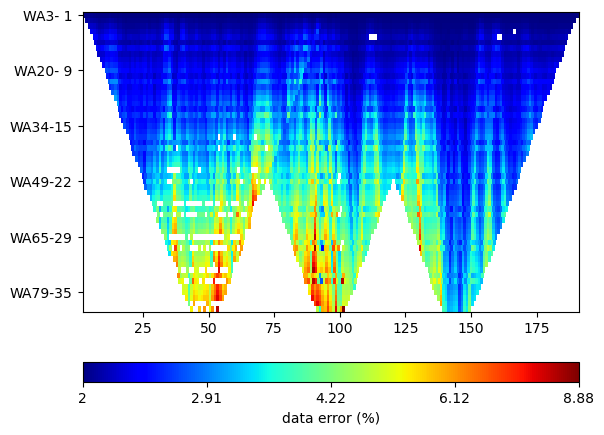

In [51]:
# ajout de bruit
relativeError=0.02      # en proportion
absoluteUError=0.00008  # en volt
# calcul de l'erreur
error=ert_m.estimateError(data,relativeError=relativeError,absoluteError=0,absoluteUError=absoluteUError)
# ajout du bruit sur la colonne 'err'
data.set('err',error)
# représentation de l'écart-type sur les données, après opération
pb.show(data,data('err')*100,label='data error (%)')

In [52]:
# lecture de la topo
topo = np.loadtxt(topofile)
topoX = topo[:,0]
topoZ = topo[:,1]

# création de deux variables, x et z
x = topoX
z = topoZ
    
# sur la variable data, ajouter la positions des électrodes, depuis le fichier de topo
for i in range(data.sensorCount()):
    data.setSensorPosition(i, [x[i], 0.0, z[i]])

In [53]:
# sauvegarde des données
data.save(outfile,'a b m n k u i err rhoa','x z');

## Partie 2: Inversion

In [54]:
# lecture du outfile et assignation à variable "dataset". 
dataset = ert_m.ERTManager(outfile)

14/04/23 - 16:40:33 - pyGIMLi - INFO - Found 2 regions.
14/04/23 - 16:40:33 - pyGIMLi - INFO - Region with smallest marker (1) set to background
14/04/23 - 16:40:33 - pyGIMLi - INFO - Creating forward mesh from region infos.
14/04/23 - 16:40:33 - pyGIMLi - INFO - Creating refined mesh (P2) to solve forward task.
14/04/23 - 16:40:33 - pyGIMLi - INFO - Use median(data values)=342.1082763861125
14/04/23 - 16:40:33 - pyGIMLi - INFO - Created startmodel from forward operator: 2884 [342.1082763861125,...,342.1082763861125]
14/04/23 - 16:40:33 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x0000028AA28A7EF0>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x0000028AA2E59F90>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x0000028AA23BD090>
min/max (data): 90.37/1613
min/max (error): 2%/8.88%
min/max (start model): 342/342
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 3.16 (dPhi = 81.05%) lam: 20
--------------------------------------------------------------------------------
inv.iter 3 ... chi² = 2.8 (dPhi = 9.59%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² = 2.71 (dPhi = 2.17%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 5 ... chi² = 2.7 (dPhi = 0.18%) lam: 20.0
###############################################################

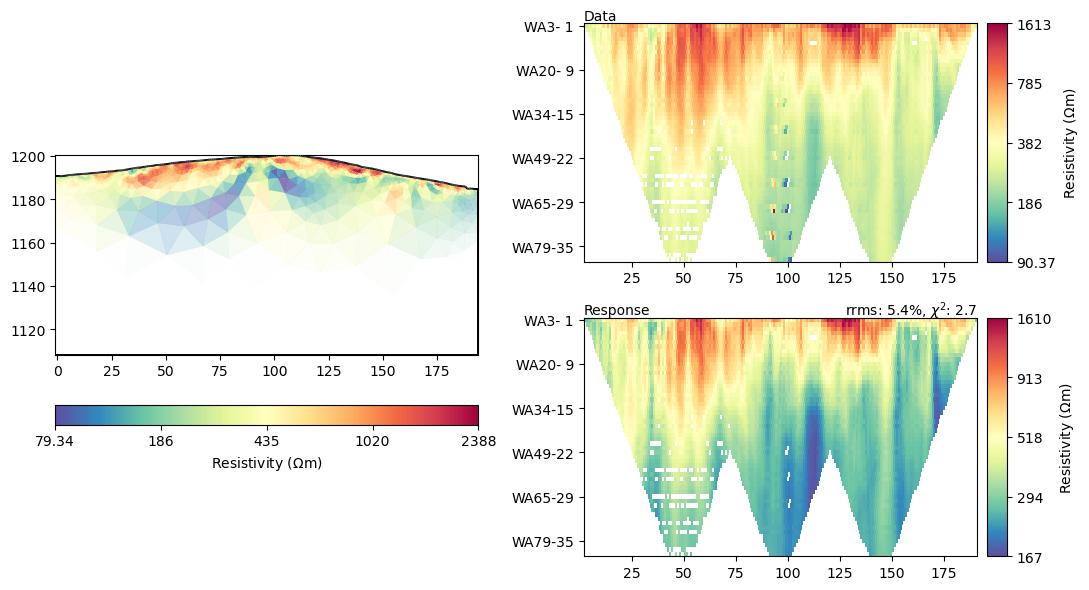

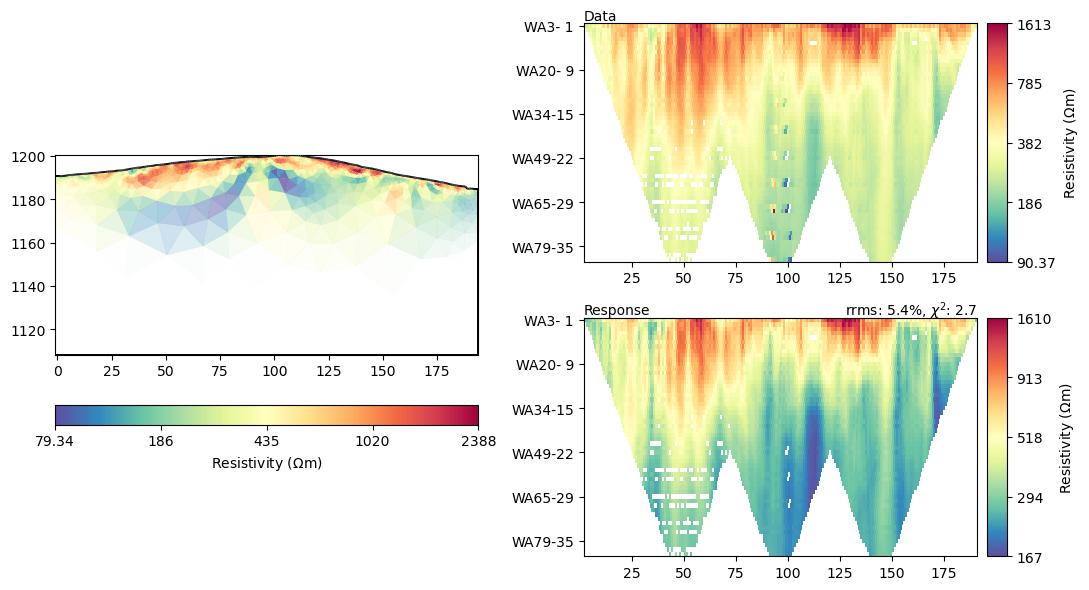

In [55]:
# inversion avec paramètres par défaut
dataI=dataset.invert(robustData=False,blockyModel=False, verbose=True)

## éléments d'entrée pour la fonction "invert"

# data : pg.DataContainerERT (Les données 'rhoa' et 'err' sur data, par défaut)
# rhoa : itérable (écrase sur data('rhoa'))
# err : itérable (écrase sur data(‘err’))
# mesh : pg.Mesh (On peut créer une maille séparememnt et l'introduire ici)

## éléments qui peuvent être modifiés pour l'inversion en elle même

# lam : float [20] (paramètre de régularisation)
# zWeight : float [0.7] (poids vertical relatif)
# maxIter : int [20] (nombre d'itérations maximal)
# robustData : bool [False] (repondération robuste des données en utilisant un schéma L1 d'inversion)
# blockyModel : bool [False] (blocky model constraint using L1 reweighting roughness vector)
# startModelIsReference : bool [False] (startmodel est le modèle de réference pour l'inversion)

## éléments de la mesh qui peuvent être modifiés directement sur "invert":
# depth, quality, paraDX, maxCellArea (profondeur, qualité, refinement entre electrodes, taille maximale de chaque cellule)

# aide de PyGimli sur : https://www.pygimli.org/pygimliapi/_generated/pygimli.meshtools.html#module-pygimli.meshtools
# paraDX (float) – relative distance for refinement nodes between two electrodes (1=none),
# e.g., 0.5 means 1 additional node between two neighboring electrodes e.g., 
# 0.33 means 2 additional equidistant nodes between two electrodes

# référence: http://resistivity.net/bert/_api/pybert.manager.html#pybert.manager.ertmanager.ERTManager.invert

# répresentation du résultat de l'inversion et le fit
dataset.showResultAndFit()

In [58]:
# Get ParaDomain mesh
meshPD = pg.Mesh(dataset.paraDomain)

(<AxesSubplot:>, <matplotlib.colorbar.Colorbar at 0x28add8af6d0>)

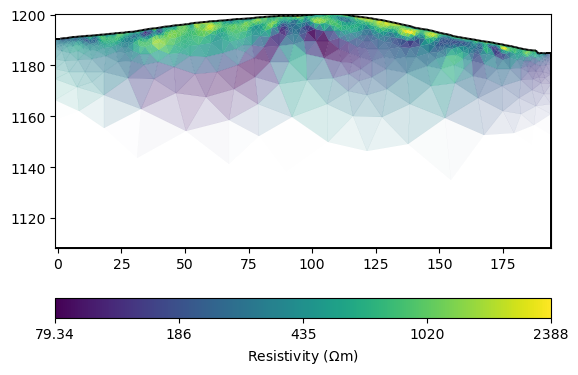

In [59]:
# Coverage
cov = dataset.coverage()
stdcov = dataset.standardizedCoverage()

# Plot with pg
pg.show(meshPD, dataI, coverage=cov, 
        cMap='viridis', 
        logScale=True, label='Resistivity ($\Omega$m)')

(<AxesSubplot:>, <matplotlib.colorbar.Colorbar at 0x28aa59f6eb0>)

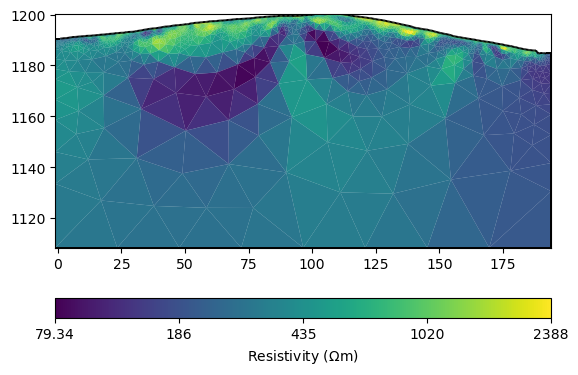

In [60]:

pg.show(meshPD, dataI, 
        cMap='viridis', 
        logScale=True, label='Resistivity ($\Omega$m)')